# 丙氨酸二肽 REST2 HREMD 采样 Quick Start

1. **加载输入结构** - 读取并可视化丙氨酸二肽分子
2. **系统准备** - 溶剂化、参数化、REST2 缩放
3. **HREMD 采样** - 运行哈密顿副本交换分子动力学
4. **结果分析** - 交换接受率、能量收敛、Ramachandran 图
5. **轨迹可视化** - 动态展示分子构象变化

为快速演示，使用最小规模的参数，结果可能不理想

## 0. 环境设置

In [1]:
# 导入依赖
import os
import sys
import pickle
import pathlib
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

# OpenMM 相关
import openmm
import openmm.app
import openmm.unit

# femto 相关
import mdtop
import femto.md.prepare
import femto.md.config
import femto.md.rest
import femto.md.hremd
import femto.md.utils.openmm
import femto.md.simulate

# 数据分析
import pyarrow
import mdtraj as md

# 可视化
try:
    import nglview as nv
    HAS_NGLVIEW = True
except ImportError:
    HAS_NGLVIEW = False
    print("nglview 未安装，将跳过交互式可视化")

print("所有依赖加载成功！")
print(f"OpenMM 版本: {openmm.__version__}")

所有依赖加载成功！
OpenMM 版本: 8.3.1


In [2]:
# 设置路径
PROJECT_ROOT = pathlib.Path('..').resolve()
DATA_DIR = PROJECT_ROOT / 'data' / 'alanine_dipeptide'
OUTPUT_DIR = PROJECT_ROOT / 'outputs' / 'quickstart'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"项目根目录: {PROJECT_ROOT}")
print(f"数据目录: {DATA_DIR}")
print(f"输出目录: {OUTPUT_DIR}")

项目根目录: /Users/yiming/projects/OMEGA
数据目录: /Users/yiming/projects/OMEGA/data/alanine_dipeptide
输出目录: /Users/yiming/projects/OMEGA/outputs/quickstart


## 1. 加载输入结构

丙氨酸二肽 (Alanine Dipeptide) 是分子模拟中最经典的测试体系之一：
- **组成**: ACE-ALA-NME（乙酰基-丙氨酸-N-甲基酰胺）
- **原子数**: 22 个原子
- **特点**: 有两个主要的构象状态 (C7eq, C7ax)，可用于验证采样方法

In [3]:
# 加载 PDB 文件
pdb_file = DATA_DIR / 'alanine-dipeptide.pdb'
topology = mdtop.Topology.from_file(str(pdb_file))

print("="*50)
print("输入结构信息")
print("="*50)
print(f"文件: {pdb_file.name}")
print(f"原子数: {len(topology.atoms)}")
print(f"残基数: {len(topology.residues)}")
print()
print("残基列表:")
for i, res in enumerate(topology.residues):
    atoms = [a.name for a in res.atoms]
    print(f"  [{i}] {res.name}: {len(atoms)} 原子 - {', '.join(atoms[:5])}{'...' if len(atoms) > 5 else ''}")

输入结构信息
文件: alanine-dipeptide.pdb
原子数: 22
残基数: 3

残基列表:
  [0] ACE: 6 原子 - H1, CH3, H2, H3, C...
  [1] ALA: 10 原子 - N, H, CA, HA, CB...
  [2] NME: 6 原子 - N, H, C, H1, H2...


In [11]:
# 可视化输入结构
if HAS_NGLVIEW:
    # 使用 mdtraj 加载用于可视化
    traj_viz = md.load(str(pdb_file))
    view = nv.show_mdtraj(traj_viz)
    view.clear_representations()
    view.add_ball_and_stick()
    view.add_label(labelType='residue', color='black')
    view.center()
    print("丙氨酸二肽结构 (ACE-ALA-NME)")
else:
    view = None
    print("跳过交互式可视化（nglview 未安装）")
    print("可以用 PyMOL 或 VMD 打开 PDB 文件查看结构")

丙氨酸二肽结构 (ACE-ALA-NME)


In [10]:
# 显示分子结构
view

NGLWidget()

## 2. 系统准备

系统准备包括以下步骤：
1. **溶剂化** - 添加 TIP3P 水分子
2. **参数化** - 使用 Amber14 力场
3. **REST2 缩放** - 对溶质的扭转和非键合相互作用应用温度缩放

In [12]:
# 配置系统准备参数
prep_config = femto.md.config.Prepare(
    ionic_strength=0.0 * openmm.unit.molar,
    neutralize=False,
    water_model='tip3p',
    box_padding=10.0 * openmm.unit.angstrom,  # 1.0 nm padding
    box_shape='cube',
    default_protein_ff=['amber14-all.xml', 'amber14/tip3pfb.xml'],
    default_ligand_ff=None
)

print("⚙️ 系统准备配置:")
print(f"   水模型: {prep_config.water_model}")
print(f"   盒子边界: {prep_config.box_padding}")
print(f"   盒子形状: {prep_config.box_shape}")
print(f"   力场: Amber14")

⚙️ 系统准备配置:
   水模型: tip3p
   盒子边界: 10.0 A
   盒子形状: cube
   力场: Amber14


In [15]:
%%time
# 执行溶剂化和参数化
print("正在准备系统（溶剂化 + 参数化）...")

topology_solvated, system = femto.md.prepare.prepare_system(
    receptor=None,
    ligand_1=topology,
    ligand_2=None,
    cofactors=None,
    config=prep_config
)

# 统计
residue_counts = {}
for res in topology_solvated.residues:
    residue_counts[res.name] = residue_counts.get(res.name, 0) + 1

n_water = residue_counts.get('HOH', 0)
solute_info = ', '.join(f'{k}({v})' for k, v in residue_counts.items() if k != 'HOH')

print()
print("="*50)
print("系统准备完成！")
print("="*50)
print(f"总原子数: {len(topology_solvated.atoms)}")
print(f"溶质残基: {solute_info}")
print(f"水分子数: {n_water}")

正在准备系统（溶剂化 + 参数化）...

系统准备完成！
总原子数: 2632
溶质残基: ACE(1), ALA(1), NME(1)
水分子数: 870
CPU times: user 623 ms, sys: 18.2 ms, total: 641 ms
Wall time: 643 ms


In [16]:
# 选择溶质原子并应用 REST2 缩放
SOLUTE_RESIDUES = ["ACE", "ALA", "NME"]
solute_query = " or ".join(f"resn {name}" for name in SOLUTE_RESIDUES)
solute_idxs = topology_solvated.select(solute_query)

print(f"溶质选择: {solute_query}")
print(f"选中原子数: {len(solute_idxs)}")

# REST2 配置
rest_config = femto.md.config.REST(
    scale_bonds=False,      # REST2 不缩放键
    scale_angles=False,     # REST2 不缩放角
    scale_torsions=True,    # 缩放扭转
    scale_nonbonded=True    # 缩放非键合
)

# 应用 REST2
femto.md.rest.apply_rest(system, solute_idxs, rest_config)

print()
print("REST2 缩放已应用:")
print(f"scale_torsions: True (降低扭转能垒)")
print(f"scale_nonbonded: True (缩放静电和LJ)")

溶质选择: resn ACE or resn ALA or resn NME
选中原子数: 22

REST2 缩放已应用:
scale_torsions: True (降低扭转能垒)
scale_nonbonded: True (缩放静电和LJ)


In [17]:
# 保存系统
system_xml_path = OUTPUT_DIR / 'system.xml'
topology_pkl_path = OUTPUT_DIR / 'topology.pkl'
system_pdb_path = OUTPUT_DIR / 'system.pdb'

system_xml_path.write_text(openmm.XmlSerializer.serialize(system))
topology_pkl_path.write_bytes(pickle.dumps(topology_solvated))
topology_solvated.to_file(str(system_pdb_path))

print("系统文件已保存:")
print(f"{system_xml_path}")
print(f"{topology_pkl_path}")
print(f"{system_pdb_path}")

系统文件已保存:
/Users/yiming/projects/OMEGA/outputs/quickstart/system.xml
/Users/yiming/projects/OMEGA/outputs/quickstart/topology.pkl
/Users/yiming/projects/OMEGA/outputs/quickstart/system.pdb


In [18]:
# 可视化溶剂化后的系统
view2 = None
if HAS_NGLVIEW:
    traj_solvated = md.load(str(system_pdb_path))
    view2 = nv.show_mdtraj(traj_solvated)
    view2.clear_representations()
    # 溶质用 ball+stick
    view2.add_ball_and_stick(selection='not water')
    # 水用 line（减少渲染开销）
    view2.add_line(selection='water', opacity=0.3)
    view2.center()
    print("溶剂化后的系统")

view2  # 必须在 if 块外面

溶剂化后的系统


NGLWidget()

## 3. HREMD 采样

### 3.1 系统平衡化

在运行 HREMD 之前，需要先对系统进行平衡化：
1. **能量最小化** - 消除不合理的原子接触
2. **NVT 升温** - 从 50K 逐渐升温到 300K
3. **NPT 平衡** - 在 300K、1 bar 下平衡密度

In [19]:
# 平衡化配置（简化版，快速运行）
equilibration_stages = [
    # 1. 能量最小化
    femto.md.config.Minimization(
        tolerance=10.0 * openmm.unit.kilocalorie_per_mole / openmm.unit.angstrom,
        max_iterations=500  # 减少迭代次数
    ),
    # 2. NVT 升温
    femto.md.config.Anneal(
        integrator=femto.md.config.LangevinIntegrator(
            timestep=1.0 * openmm.unit.femtosecond,
            friction=1.0 / openmm.unit.picosecond
        ),
        temperature_initial=50.0 * openmm.unit.kelvin,
        temperature_final=300.0 * openmm.unit.kelvin,
        n_steps=5000,  # 5 ps
        frequency=100
    ),
    # 3. NPT 平衡
    femto.md.config.Simulation(
        integrator=femto.md.config.LangevinIntegrator(
            timestep=2.0 * openmm.unit.femtosecond,
            friction=1.0 / openmm.unit.picosecond
        ),
        temperature=300.0 * openmm.unit.kelvin,
        pressure=1.0 * openmm.unit.bar,
        n_steps=10000  # 20 ps
    )
]

print("平衡化阶段:")
print("1. 能量最小化 (500 steps)")
print("2. NVT 升温 (50K → 300K, 5 ps)")
print("3. NPT 平衡 (300K, 1 bar, 20 ps)")

平衡化阶段:
1. 能量最小化 (500 steps)
2. NVT 升温 (50K → 300K, 5 ps)
3. NPT 平衡 (300K, 1 bar, 20 ps)


In [20]:
%%time
# 执行平衡化
print("正在平衡化系统...")
print()

equilibrated_coords = femto.md.simulate.simulate_state(
    system,
    topology_solvated,
    state={femto.md.rest.REST_CTX_PARAM: 1.0},
    stages=equilibration_stages,
    platform='CPU'
)

print()
print("平衡化完成！")

正在平衡化系统...


平衡化完成！
CPU times: user 1min 57s, sys: 58.3 s, total: 2min 55s
Wall time: 37.9 s


### 3.2 配置 HREMD 参数

为了快速演示，我们使用最小规模的参数：
- **副本数**: 4（正式运行建议 8-16）
- **温度范围**: 300K - 500K
- **采样轮数**: 50（正式运行建议 1000+）

In [21]:
# 温度梯度设计（几何分布）
T_min = 300.0 * openmm.unit.kelvin
T_max = 500.0 * openmm.unit.kelvin
n_replicas = 4  # 最小规模

temperatures = [
    T_min * (T_max / T_min) ** (i / (n_replicas - 1))
    for i in range(n_replicas)
]

print("温度阶梯 (几何分布):")
for i, T in enumerate(temperatures):
    print(f"State {i}: {T.value_in_unit(openmm.unit.kelvin):.1f} K")

# 计算 beta 缩放因子
betas = [1.0 / (openmm.unit.MOLAR_GAS_CONSTANT_R * T) for T in temperatures]
states = [{femto.md.rest.REST_CTX_PARAM: beta / betas[0]} for beta in betas]
states = [femto.md.utils.openmm.evaluate_ctx_parameters(s, system) for s in states]

print()
print("Beta 缩放因子 (β_m/β_0):")
for i, s in enumerate(states):
    print(f"State {i}: {s[femto.md.rest.REST_CTX_PARAM]:.4f}")

温度阶梯 (几何分布):
State 0: 300.0 K
State 1: 355.7 K
State 2: 421.7 K
State 3: 500.0 K

Beta 缩放因子 (β_m/β_0):
State 0: 1.0000
State 1: 0.8434
State 2: 0.7114
State 3: 0.6000


In [22]:
# HREMD 配置（最小规模，快速演示）
hremd_config = femto.md.config.HREMD(
    temperature=T_min,
    n_warmup_steps=1000,        # 2 ps warmup
    n_steps_per_cycle=100,      # 0.2 ps per cycle
    n_cycles=50,                # 50 cycles = 10 ps 采样
    swap_mode='neighbours',     # 相邻态交换
    max_swaps=None,
    trajectory_interval=5,      # 每 5 cycles 保存一帧
    checkpoint_interval=25,
    trajectory_enforce_pbc=True
)

warmup_ps = hremd_config.n_warmup_steps * 2 / 1000
sampling_ps = hremd_config.n_cycles * hremd_config.n_steps_per_cycle * 2 / 1000

print("HREMD 配置 (Quick Start 最小规模):")
print(f"副本数: {n_replicas}")
print(f"Warmup: {warmup_ps:.1f} ps")
print(f"采样时间: {sampling_ps:.1f} ps")
print(f"总轮数: {hremd_config.n_cycles}")
print(f"交换模式: neighbours")
print(f"轨迹保存: 每 {hremd_config.trajectory_interval} 轮")
print()

HREMD 配置 (Quick Start 最小规模):
副本数: 4
Warmup: 2.0 ps
采样时间: 10.0 ps
总轮数: 50
交换模式: neighbours
轨迹保存: 每 5 轮



In [23]:
# 创建模拟对象
integrator_config = femto.md.config.LangevinIntegrator(
    timestep=2.0 * openmm.unit.femtosecond,
    friction=1.0 / openmm.unit.picosecond
)
integrator = femto.md.utils.openmm.create_integrator(integrator_config, T_min)

simulation = femto.md.utils.openmm.create_simulation(
    system,
    topology_solvated,
    equilibrated_coords,
    integrator=integrator,
    state=states[0],
    platform='CPU'
)

print("模拟对象创建完成")

模拟对象创建完成


In [24]:
%%time
# 运行 HREMD
hremd_output_dir = OUTPUT_DIR / 'hremd'
hremd_output_dir.mkdir(exist_ok=True)

print("="*50)
print("开始 REST2 HREMD 采样")
print("="*50)
print(f"输出目录: {hremd_output_dir}")
print()

try:
    femto.md.hremd.run_hremd(
        simulation,
        states,
        hremd_config,
        output_dir=hremd_output_dir
    )
    print()
    print("="*50)
    print("HREMD 采样完成！")
    print("="*50)
except Exception as e:
    print(f"错误: {e}")
    raise

开始 REST2 HREMD 采样
输出目录: /Users/yiming/projects/OMEGA/outputs/quickstart/hremd



100%|██████████| 50/50 [00:50<00:00,  1.01s/it]



HREMD 采样完成！
CPU times: user 3min 17s, sys: 1min 34s, total: 4min 51s
Wall time: 1min 1s


## 4. 结果分析

分析 HREMD 采样结果：
- **交换接受率** - 评估温度梯度设计是否合理
- **能量收敛** - 检查系统是否达到平衡
- **Ramachandran 图** - 分析构象分布

In [25]:
# 加载采样数据
samples_file = hremd_output_dir / 'samples.arrow'

with pyarrow.OSFile(str(samples_file), 'rb') as f:
    reader = pyarrow.RecordBatchStreamReader(f)
    table = reader.read_all()
    df = table.to_pandas()

print(f"加载采样数据: {len(df)} 个循环")
print(f"数据列: {list(df.columns)}")

加载采样数据: 50 个循环
数据列: ['step', 'u_kn', 'replica_to_state_idx', 'n_proposed_swaps', 'n_accepted_swaps']


交换接受率分析

相邻态交换接受率:
State 0 ↔ 1: 59.1%
State 1 ↔ 2: 66.7%
State 2 ↔ 3: 68.2%

平均接受率: 64.6%
接受率偏高，建议增大温度间隔


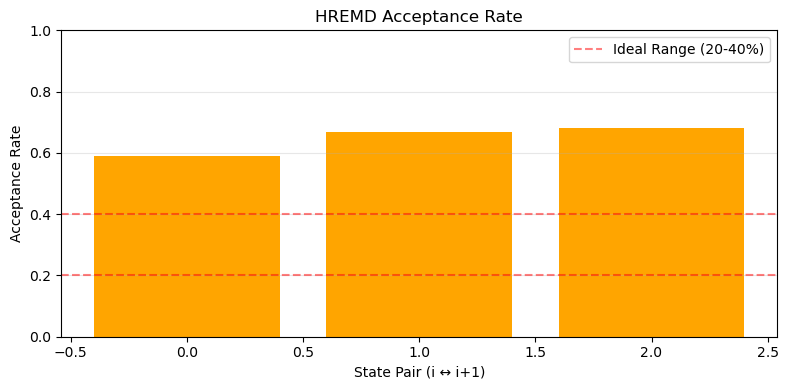


图片已保存: /Users/yiming/projects/OMEGA/outputs/quickstart/acceptance_rates.png


In [32]:
# 分析交换接受率
print("="*50)
print("交换接受率分析")
print("="*50)

if 'n_proposed_swaps' in df.columns and 'n_accepted_swaps' in df.columns:
    n_prop = np.array(df['n_proposed_swaps'].iloc[-1])
    n_acc = np.array(df['n_accepted_swaps'].iloc[-1])
    
    # Calculate acceptance rates safely for each state pair
    acceptance_rates = []
    for i in range(len(n_acc)):
        acc = np.array(n_acc[i], dtype=float)
        prop = np.array(n_prop[i], dtype=float)
        rates = np.divide(acc, prop, out=np.zeros_like(acc), where=(prop > 0))
        acceptance_rates.append(rates)

    acceptance_rates = np.array(acceptance_rates)
    # Extract off-diagonal elements (state i <-> i+1)
    acceptance_rates = np.array([acceptance_rates[i, i+1] for i in range(len(acceptance_rates)-1)])
    
    print("\n相邻态交换接受率:")
    for i, rate in enumerate(acceptance_rates):
        print(f"State {i} ↔ {i+1}: {100*rate:.1f}%")
    
    avg_rate = np.mean(acceptance_rates)
    print(f"\n平均接受率: {100*avg_rate:.1f}%")
    if 0.20 <= avg_rate <= 0.40:
        print("接受率在理想范围 (20-40%)")
    elif avg_rate > 0.40:
        print("接受率偏高，建议增大温度间隔")
    else:
        print("接受率偏低，建议减小温度间隔")
    
    # 绘图
    fig, ax = plt.subplots(figsize=(8, 4))
    colors = ['green' if 0.20 <= r <= 0.40 else 'orange' for r in acceptance_rates]
    bars = ax.bar(range(len(acceptance_rates)), acceptance_rates, color=colors)
    ax.axhline(0.20, color='red', linestyle='--', alpha=0.5, label='Ideal Range (20-40%)')
    ax.axhline(0.40, color='red', linestyle='--', alpha=0.5)
    ax.set_xlabel('State Pair (i ↔ i+1)')
    ax.set_ylabel('Acceptance Rate')
    ax.set_title('HREMD Acceptance Rate')
    ax.set_ylim([0, 1.0])
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'acceptance_rates.png', dpi=150)
    plt.show()
    print(f"\n图片已保存: {OUTPUT_DIR / 'acceptance_rates.png'}")

副本游走分析


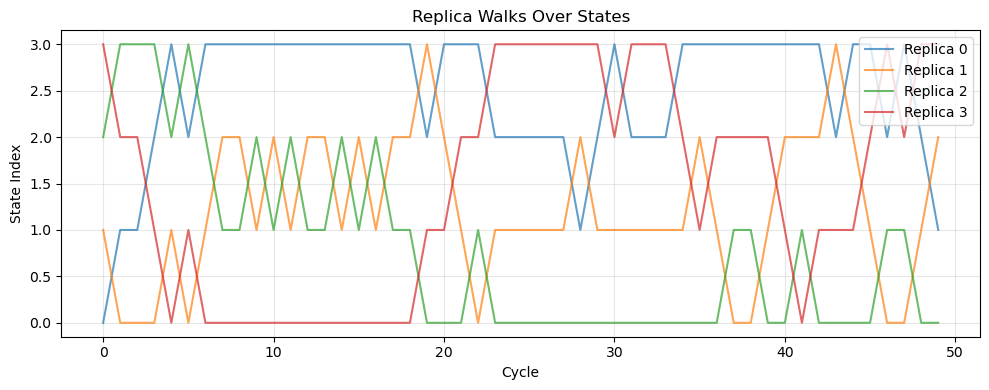


状态覆盖度:
   Replica 0: 4/4 states (100%)
   Replica 1: 4/4 states (100%)
   Replica 2: 4/4 states (100%)
   Replica 3: 4/4 states (100%)


In [33]:
# 分析副本游走
print("="*50)
print("副本游走分析")
print("="*50)

if 'replica_to_state_idx' in df.columns:
    replica_indices = np.array([np.array(x) for x in df['replica_to_state_idx']])
    
    fig, ax = plt.subplots(figsize=(10, 4))
    for i in range(n_replicas):
        ax.plot(replica_indices[:, i], alpha=0.7, linewidth=1.5, label=f'Replica {i}')
    ax.set_xlabel('Cycle')
    ax.set_ylabel('State Index')
    ax.set_title('Replica Walks Over States')
    ax.legend(loc='upper right')
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'replica_walk.png', dpi=150)
    plt.show()
    
    # 统计状态覆盖
    print("\n状态覆盖度:")
    for i in range(n_replicas):
        unique = len(np.unique(replica_indices[:, i]))
        pct = 100 * unique / n_replicas
        print(f"   Replica {i}: {unique}/{n_replicas} states ({pct:.0f}%)")

Ramachandran 分析

加载轨迹: 10 帧
φ 范围: [-156.5°, -56.5°]
ψ 范围: [-172.1°, 161.3°]


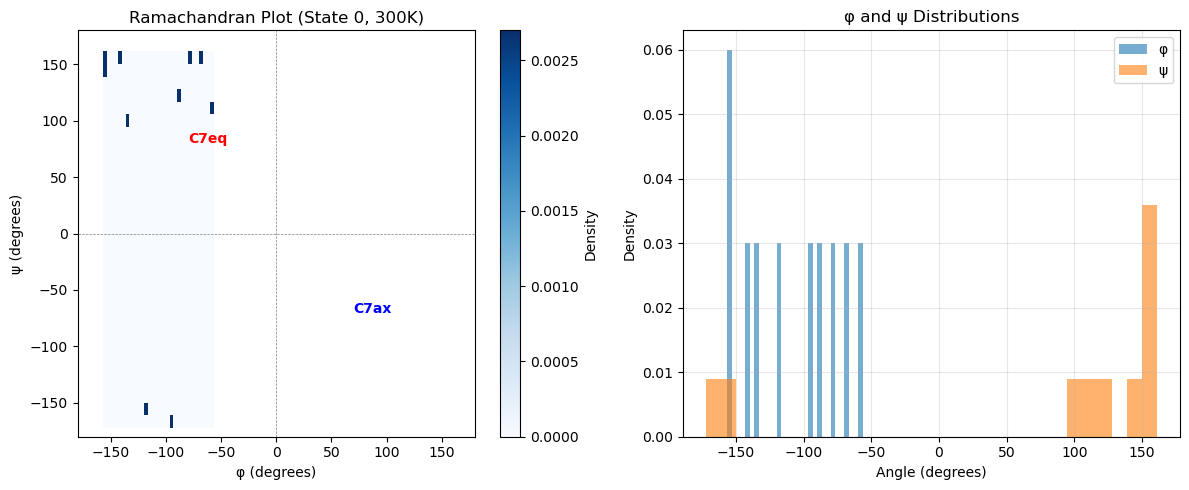


构象占比:
   C7eq: 0.0%
   C7ax: 0.0%
   其他: 100.0%


In [35]:
# 分析扭转角（Ramachandran 图）
print("="*50)
print("Ramachandran 分析")
print("="*50)

# 加载轨迹
traj_file = hremd_output_dir / 'trajectories' / 'r0.dcd'
if traj_file.exists():
    traj = md.load(str(traj_file), top=str(system_pdb_path))
    print(f"\n加载轨迹: {len(traj)} 帧")
    
    # 计算 phi, psi 角
    phi_indices, phi = md.compute_phi(traj)
    psi_indices, psi = md.compute_psi(traj)
    
    phi_deg = np.rad2deg(phi[:, 0])
    psi_deg = np.rad2deg(psi[:, 0])
    
    print(f"φ 范围: [{phi_deg.min():.1f}°, {phi_deg.max():.1f}°]")
    print(f"ψ 范围: [{psi_deg.min():.1f}°, {psi_deg.max():.1f}°]")
    
    # 绘制 Ramachandran 图
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # 2D 直方图
    h = axes[0].hist2d(phi_deg, psi_deg, bins=30, cmap='Blues', density=True)
    axes[0].set_xlabel('φ (degrees)')
    axes[0].set_ylabel('ψ (degrees)')
    axes[0].set_title('Ramachandran Plot (State 0, 300K)')
    axes[0].axhline(0, color='gray', linewidth=0.5, linestyle='--')
    axes[0].axvline(0, color='gray', linewidth=0.5, linestyle='--')
    axes[0].set_xlim([-180, 180])
    axes[0].set_ylim([-180, 180])
    
    # 标注构象区域
    axes[0].text(-80, 80, 'C7eq', fontsize=10, color='red', weight='bold')
    axes[0].text(70, -70, 'C7ax', fontsize=10, color='blue', weight='bold')
    plt.colorbar(h[3], ax=axes[0], label='Density')
    
    # 1D 分布
    axes[1].hist(phi_deg, bins=30, alpha=0.6, label='φ', density=True)
    axes[1].hist(psi_deg, bins=30, alpha=0.6, label='ψ', density=True)
    axes[1].set_xlabel('Angle (degrees)')
    axes[1].set_ylabel('Density')
    axes[1].set_title('φ and ψ Distributions')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'ramachandran.png', dpi=150)
    plt.show()
    
    # 构象占比统计
    c7eq_mask = (phi_deg > -110) & (phi_deg < -50) & (psi_deg > 60) & (psi_deg < 100)
    c7ax_mask = (phi_deg > 50) & (phi_deg < 100) & (psi_deg > -100) & (psi_deg < -40)
    
    c7eq_frac = c7eq_mask.sum() / len(phi_deg)
    c7ax_frac = c7ax_mask.sum() / len(phi_deg)
    
    print("\n构象占比:")
    print(f"   C7eq: {100*c7eq_frac:.1f}%")
    print(f"   C7ax: {100*c7ax_frac:.1f}%")
    print(f"   其他: {100*(1-c7eq_frac-c7ax_frac):.1f}%")
else:
    print(f"轨迹文件不存在: {traj_file}")

In [38]:
# 加载并可视化轨迹
view_traj = None
if HAS_NGLVIEW and traj_file.exists():
    print("="*50)
    print("轨迹可视化")
    print("="*50)
    
    # 只显示溶质（去除水分子以便更清楚地看到构象变化）
    solute_atoms = traj.topology.select('not water')
    traj_solute = traj.atom_slice(solute_atoms)
    
    print(f"\n轨迹信息:")
    print(f"   总帧数: {len(traj_solute)}")
    print(f"   溶质原子数: {traj_solute.n_atoms}")
    
    # 创建可视化
    view_traj = nv.show_mdtraj(traj_solute)
    view_traj.clear_representations()
    view_traj.add_ball_and_stick()
    view_traj.add_label(labelType='residue', color='black')
    view_traj.center()
    
    print("\n轨迹动画 (点击播放按钮开始)")
    print("   - 使用滑块可以手动选择帧")
    print("   - 观察分子在 C7eq 和 C7ax 构象间的转换")
    
elif not HAS_NGLVIEW:
    print("nglview 未安装，跳过交互式可视化")
    print("   可以用 VMD 或 PyMOL 打开轨迹文件:")
    print(f"   - 拓扑: {system_pdb_path}")
    print(f"   - 轨迹: {traj_file}")
else:
    print(f"轨迹文件不存在: {traj_file}")

轨迹可视化

轨迹信息:
   总帧数: 10
   溶质原子数: 22

轨迹动画 (点击播放按钮开始)
   - 使用滑块可以手动选择帧
   - 观察分子在 C7eq 和 C7ax 构象间的转换


In [39]:
# 显示轨迹动画
view_traj

NGLWidget(max_frame=9)

构象演化时间序列


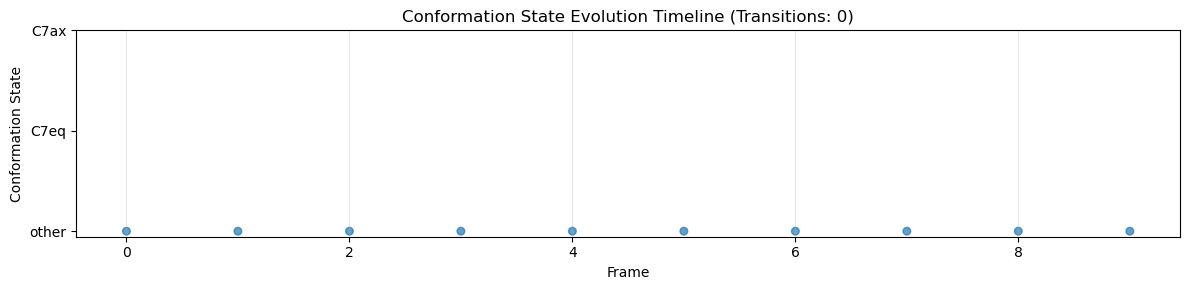


构象转换统计:
   总转换次数: 0
   平均停留帧数: 10.0


In [44]:
# 构象演化时间序列
if traj_file.exists():
    print("="*50)
    print("构象演化时间序列")
    print("="*50)
    
    # 定义构象状态
    state_labels = np.full(len(phi_deg), 'other', dtype=object)
    state_labels[c7eq_mask] = 'C7eq'
    state_labels[c7ax_mask] = 'C7ax'
    
    # 数值编码
    state_code = np.zeros(len(phi_deg))
    state_code[state_labels == 'C7eq'] = 1
    state_code[state_labels == 'C7ax'] = 2
    
    # 计算转换次数
    transitions = np.sum(state_labels[:-1] != state_labels[1:])
    
    fig, ax = plt.subplots(figsize=(12, 3))
    scatter = ax.scatter(range(len(phi_deg)), state_code, c=state_code, cmap='tab10', s=30, alpha=0.7)
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['other', 'C7eq', 'C7ax'])
    ax.set_xlabel('Frame')
    ax.set_ylabel('Conformation State')
    ax.set_title(f'Conformation State Evolution Timeline (Transitions: {transitions})')
    ax.grid(alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'conformation_timeline.png', dpi=150)
    plt.show()
    
    print(f"\n构象转换统计:")
    print(f"   总转换次数: {transitions}")
    print(f"   平均停留帧数: {len(phi_deg) / (transitions + 1):.1f}")

## 6. 总结

In [42]:
print("="*60)
print("REST2 HREMD Quick Start 总结")
print("="*60)

print("\n系统配置:")
print(f"   - 体系: 丙氨酸二肽 (ACE-ALA-NME)")
print(f"   - 总原子数: {len(topology_solvated.atoms)}")
print(f"   - 水分子数: {n_water}")
print(f"   - 副本数: {n_replicas}")
print(f"   - 温度范围: {T_min.value_in_unit(openmm.unit.kelvin):.0f}K - {T_max.value_in_unit(openmm.unit.kelvin):.0f}K")

print("\n采样质量:")
if 'acceptance_rates' in dir():
    print(f"   - 平均交换接受率: {100*np.mean(acceptance_rates):.1f}%")
if 'c7eq_frac' in dir():
    print(f"   - C7eq 占比: {100*c7eq_frac:.1f}%")
    print(f"   - C7ax 占比: {100*c7ax_frac:.1f}%")
if 'transitions' in dir():
    print(f"   - 构象转换次数: {transitions}")

print("\n输出文件:")
for f in OUTPUT_DIR.glob('*'):
    if f.is_file():
        size_kb = f.stat().st_size / 1024
        print(f"   - {f.name} ({size_kb:.1f} KB)")

print("\n下一步建议:")
print("   1. 增加采样轮数 (n_cycles=1000+) 获得更可靠的构象分布")
print("   2. 增加副本数 (n_replicas=8) 改善温度空间采样")
print("   3. 使用 GPU 加速 (platform='CUDA') 提升 10-20 倍速度")
print("   4. 进行 MBAR 重加权获得无偏构象分布")

print("\n" + "="*60)
print("Quick Start 完成！")
print("="*60)

REST2 HREMD Quick Start 总结

系统配置:
   - 体系: 丙氨酸二肽 (ACE-ALA-NME)
   - 总原子数: 2632
   - 水分子数: 870
   - 副本数: 4
   - 温度范围: 300K - 500K

采样质量:
   - 平均交换接受率: 64.6%
   - C7eq 占比: 0.0%
   - C7ax 占比: 0.0%
   - 构象转换次数: 0

输出文件:
   - topology.pkl (284.2 KB)
   - replica_walk.png (131.0 KB)
   - ramachandran.png (71.6 KB)
   - system.xml (541.1 KB)
   - acceptance_rates.png (34.8 KB)
   - conformation_timeline.png (18.6 KB)
   - system.pdb (208.7 KB)

下一步建议:
   1. 增加采样轮数 (n_cycles=1000+) 获得更可靠的构象分布
   2. 增加副本数 (n_replicas=8) 改善温度空间采样
   3. 使用 GPU 加速 (platform='CUDA') 提升 10-20 倍速度
   4. 进行 MBAR 重加权获得无偏构象分布

Quick Start 完成！
